In [2]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.random import random_circuit
import random
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Kraus, SuperOp, Operator
import pickle
import numpy as np
from scipy.linalg import sqrtm

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [3]:
#method for randomly generating a POVM set of size d on some n-dimensional basis space (should be n = 2**q where q is number of qubits) 
def generate_POVMs(n, d=-1, seed=10):
    np.random.seed(seed)
    #if d is negative defaults to an informationally complete set (n^2 many)
    if d<1:
        d = n**2
    #first, generate d linearly independent non-negative operators
    vectors = []
    for i in range(d):
        real = np.random.randn(n)
        imag = np.random.randn(n)
        vector = real + imag * 1j
        vector /= np.linalg.norm(vector)
        vectors.append(vector)
    #sum up all of the vectors
    G = np.zeros((n, n), dtype=np.complex128)
    for vector in vectors:
        G += np.outer(vector, np.conj(vector))
    #take square root of matrix, take inverse of matrix
    Ginvhalf = np.linalg.inv(sqrtm(G))
    #compute POVMs
    POVMs = []
    for vector in vectors:
        E = Ginvhalf @ vector
        POVMs.append(E) #stores only one half of a POVM element -- to save on space!
    return np.array(POVMs)

In [4]:
### feed me a noiseless quantum circuit, I will save all the data from that.

"""
circ: a QuantumCircuit without measurement at the end
name: name you want to save it as
povm: whether to use POVM or standard measurements
n_meas: how many POVM measurements is the set?
seed: random number for simulation generation
shots: number of shots
"""
def get_noiseless_circuit_data(circ, name, povm=False, n_meas=-1, seed=15, shots=10000):
    n = circ.num_qubits
    
    #find statevector
    psi = qi.Statevector.from_instruction(circ).data #assuming a pure state
    #find density matrix
    rho = qi.DensityMatrix.from_instruction(circ).data
    
    if povm:
        if n_meas < 0:
            n_meas = 2**(2*n)
        POVM_set = generate_POVMs(2**n, n_meas, seed)
        probabilities = np.array([ (np.abs(np.dot(np.conj(POVM), psi))**2) for POVM in POVM_set])
        with open(f"data/{name}_POVM", "wb") as f:
            pickle.dump(POVM_set, f)
        print(f"Saved POVM set for {name}: {n} qubits, {n_meas} measurement outcomes")
    else:
        print("using standard measurement basis")
        #standard measurement
        probabilities = np.array([ np.abs(psi[i])**2 for i in range(len(psi))])
    with open(f"data/{name}_statistics", "w") as f:
        if not povm:
            f.write("standard\n")
        for i in range(len(probabilities)):
            f.write(f"{i} {probabilities[i]}\n")
    with open(f"data/{name}_density","wb") as file:
        pickle.dump(rho, file)
    print(f"Saved statistics and density matrix for {name}")

In [25]:
n = 2
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0,1)
get_noiseless_circuit_data(circ, "GHZ_2", povm=True)

n = 5
depth = 10
name = f"random_{n}_1000"
randcirc = random_circuit(n,depth,measure=False, seed=1517)
get_noiseless_circuit_data(randcirc, name, povm=True)

Saved POVM set for GHZ_2: 2 qubits, 16 measurement outcomes
Saved statistics and density matrix for GHZ_2
Saved POVM set for random_5_1000: 5 qubits, 1024 measurement outcomes
Saved statistics and density matrix for random_5_1000


In [34]:
n=8
circ = QuantumCircuit(n)
circ.h(0)
circ.cx(0,1)
circ.cx(1,2)
circ.cx(2,3)
circ.cx(3,4)
circ.cx(4,5)
circ.cx(5,6)
circ.cx(6,7)
get_noiseless_circuit_data(circ, "GHZ_8_32768", povm=True, n_meas=2**(2*n-1),seed=52)

Saved POVM set for GHZ_8_32768: 8 qubits, 32768 measurement outcomes
Saved statistics and density matrix for GHZ_8_32768


In [30]:
circ = QuantumCircuit(5)
circ.h(0)
circ.cx(0,1)
circ.cx(1,2)
circ.cx(2,3)
circ.cx(3,4)
get_noiseless_circuit_data(circ, "GHZ_5_256", povm=True)

Saved POVM set for GHZ_5_256: 5 qubits, 1024 measurement outcomes
Saved statistics and density matrix for GHZ_5_256


In [5]:
povms = [1500, 2000, 2500]
for povm in povms:
    circ = QuantumCircuit(6)
    circ.h(0)
    circ.cx(0,1)
    circ.cx(1,2)
    circ.cx(2,3)
    circ.cx(3,4)
    circ.cx(4,5)
    get_noiseless_circuit_data(circ, f"GHZ_6_{povm}", povm=True, n_meas = povm)

Saved POVM set for GHZ_6_1500: 6 qubits, 1500 measurement outcomes
Saved statistics and density matrix for GHZ_6_1500
Saved POVM set for GHZ_6_2000: 6 qubits, 2000 measurement outcomes
Saved statistics and density matrix for GHZ_6_2000
Saved POVM set for GHZ_6_2500: 6 qubits, 2500 measurement outcomes
Saved statistics and density matrix for GHZ_6_2500


In [40]:
import subprocess
commands = []
povms = [40,60,80,100,200,300,400,500,600,700,800,900,1024]
for k in povms:
    command = f'python ./qst.py 6 1 -n "GHZ_6_{k}"'
    commands.append(command)
' ; '.join(commands)

'python ./qst.py 6 1 -n "GHZ_6_40" ; python ./qst.py 6 1 -n "GHZ_6_60" ; python ./qst.py 6 1 -n "GHZ_6_80" ; python ./qst.py 6 1 -n "GHZ_6_100" ; python ./qst.py 6 1 -n "GHZ_6_200" ; python ./qst.py 6 1 -n "GHZ_6_300" ; python ./qst.py 6 1 -n "GHZ_6_400" ; python ./qst.py 6 1 -n "GHZ_6_500" ; python ./qst.py 6 1 -n "GHZ_6_600" ; python ./qst.py 6 1 -n "GHZ_6_700" ; python ./qst.py 6 1 -n "GHZ_6_800" ; python ./qst.py 6 1 -n "GHZ_6_900" ; python ./qst.py 6 1 -n "GHZ_6_1024"'

In [35]:
def get_noisy_circuit_data(circ, noise_model, name, povm=False, n_meas=-1, seed=15, shots=10000):
        n = circ.num_qubits
        if povm:
            if n_meas < 0:
                n_meas = 2**(2*n)
            POVM_set = generate_POVMs(2**n, n_meas, seed)
            povm_circuit = QuantumCircuit(len(POVM_set), len(POVM_set))
            for i in range(len(POVM_set)):
                v = POVM_set[i]
                A = np.outer(v, np.conj(v))
                Lambda, U = np.linalg.eigh(A)
                sqrt_Lambda = np.diag(np.sqrt(Lambda))
                sqrt_A = U @ sqrt_Lambda @ np.conj(U.T)
                E = Operator(sqrt_A)
                povm_circuit.unitary(E, [i])
            povm_circuit.measure_all()

            full_circuit = circ + povm_circuit
        else:
            pass
        
        sim_noise = AerSimulator(noise_model=noise_model)
        tcirc = transpile(full_circuit, sim_noise)
        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts()
        #turn counts into estimated probabilities
        probabilities = np.zeros(2**n)
        for count in counts:
            idx = int(count,2)
            probabilities[idx] = counts[count]/shots
        print(probabilities)
        plot_histogram(counts)

In [ ]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)
# Test Circuit (GHZ 4)
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)


get_noisy_circuit_data(circ, noise_bit_flip, "noisyGHZ4", povm=True)

In [7]:
def get_two_circuit_data(circ1, circ2, name, povm=False, weight=0.5, n_meas=-1, seed=15, shots=10000):
    if weight <= 0 or weight >= 1:
        print("needs to have nontrivial weight on both circuits!")
        return
    n = circ1.num_qubits
    rho1 = qi.DensityMatrix.from_instruction(circ1).data
    rho2 = qi.DensityMatrix.from_instruction(circ2).data
    mixed = weight*rho1 + (1-weight)*rho2
    if povm:
        if n_meas < 0:
            n_meas = 2**(2*n)
        POVM_set = generate_POVMs(2**n, n_meas, seed)
        probabilities = np.array([ np.trace(np.outer(POVM, np.conj(POVM)) @ mixed).real for POVM in POVM_set])
        with open(f"data/{name}_POVM", "wb") as f:
            pickle.dump(POVM_set, f)
        print(f"Saved POVM set for {name}: {n} qubits, {n_meas} measurement outcomes")
    else:
        print("using standard measurement basis")
        #standard measurement
        probabilities = np.array([ np.abs(mixed[i][i])**2 for i in range(2**n)])
    with open(f"data/{name}_statistics", "w") as f:
        if not povm:
            f.write("standard\n")
        for i in range(len(probabilities)):
            f.write(f"{i} {probabilities[i]}\n")
    with open(f"data/{name}_density","wb") as file:
        pickle.dump(mixed, file)
    print(f"Saved statistics and density matrix for {name}")

In [14]:
circ1 = QuantumCircuit(6)
circ1.h(0)
circ1.cx(0,1)
circ1.cx(1,2)
circ1.cx(2,3)
circ1.cx(3,4)
circ1.cx(4,5)
circ2 = QuantumCircuit(6)
get_two_circuit_data(circ1, circ2, "mixed6_ghz_w0.9", povm=True, n_meas = 1024, weight=0.9)

Saved POVM set for mixed6_ghz_w0.9: 6 qubits, 1024 measurement outcomes
Saved statistics and density matrix for mixed6_ghz_w0.9


In [128]:
commands = []
circs = ["random_2_2", "random_3_2", "random_4_2", "random_5_2", "random_6_2", "random_7_2", "random_8_2"]
k = 2
for circ in circs:
    command = f'python ./qst.py {k} 1 -n "{circ}"'
    commands.append(command)
    k += 1
' ; '.join(commands)

'python ./qst.py 2 1 -n "random_2_2" ; python ./qst.py 3 1 -n "random_3_2" ; python ./qst.py 4 1 -n "random_4_2" ; python ./qst.py 5 1 -n "random_5_2" ; python ./qst.py 6 1 -n "random_6_2" ; python ./qst.py 7 1 -n "random_7_2" ; python ./qst.py 8 1 -n "random_8_2"'

In [127]:
#random circuit
n = 3
depth = 100
name = f"random_{n}_{depth}"

circ = random_circuit(n,depth,measure=False, seed=932)
get_noiseless_circuit_data(circ, name, povm=True, n_meas = 2**(2*n-1))
# simulator = Aer.get_backend('aer_simulator')
# tcirc = transpile(circ, simulator)
# result = simulator.run(tcirc, shots=10000).result()
# counts = result.get_counts()
# print(counts)

# with open(f"data/{name}_counts", "w") as f:
#     for count in counts:
#         f.write(f"{int(count,2)} {counts[count]/10000}")
#         f.write("\n")
# print(f"saved {name} counts")
# circ = random_circuit(n,depth,measure=False, seed=1515)
#rho = qi.DensityMatrix.from_instruction(circ)
# with open(f"data/{name}_density","wb") as file:
#         pickle.dump(rho, file)
# print(f"saved {name} density matrix")
#plot_histogram(counts, figsize = (14,10), filename='histogram.png')

Saved POVM set for random_3_100: 3 qubits, 32 measurement outcomes
Saved statistics and density matrix for random_3_100


C:\Users\aunik\miniconda3\envs\probmodels\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


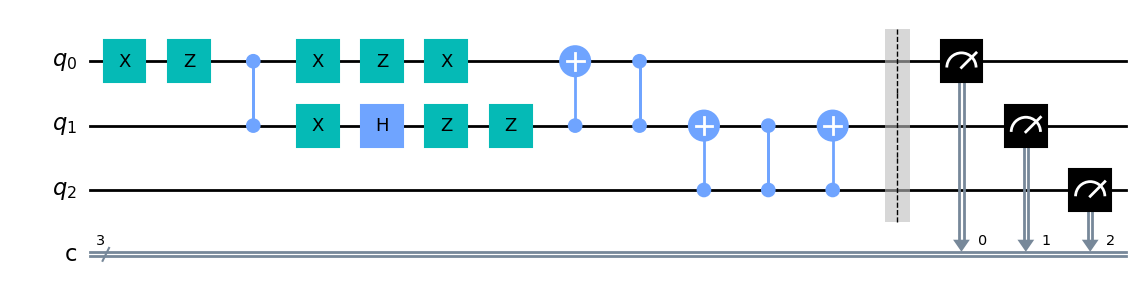

In [130]:
n = 3
depth = 15
qc = QuantumCircuit(n,n)
for i in range(depth):
    x = random.sample(range(n),2)
    gate = random.sample(range(5),1)[0]
    if gate==0:
        qc.x(x[0])
    elif gate==1:
        qc.cz(x[0],x[1])
    elif gate==2:
        qc.z(x[0])
    elif gate==3:
        qc.cx(x[0],x[1])
    elif gate==4:
        qc.h(x[0])
qc.barrier()
qc.measure(range(n),range(n))
qc.draw('mpl', filename='circuit')

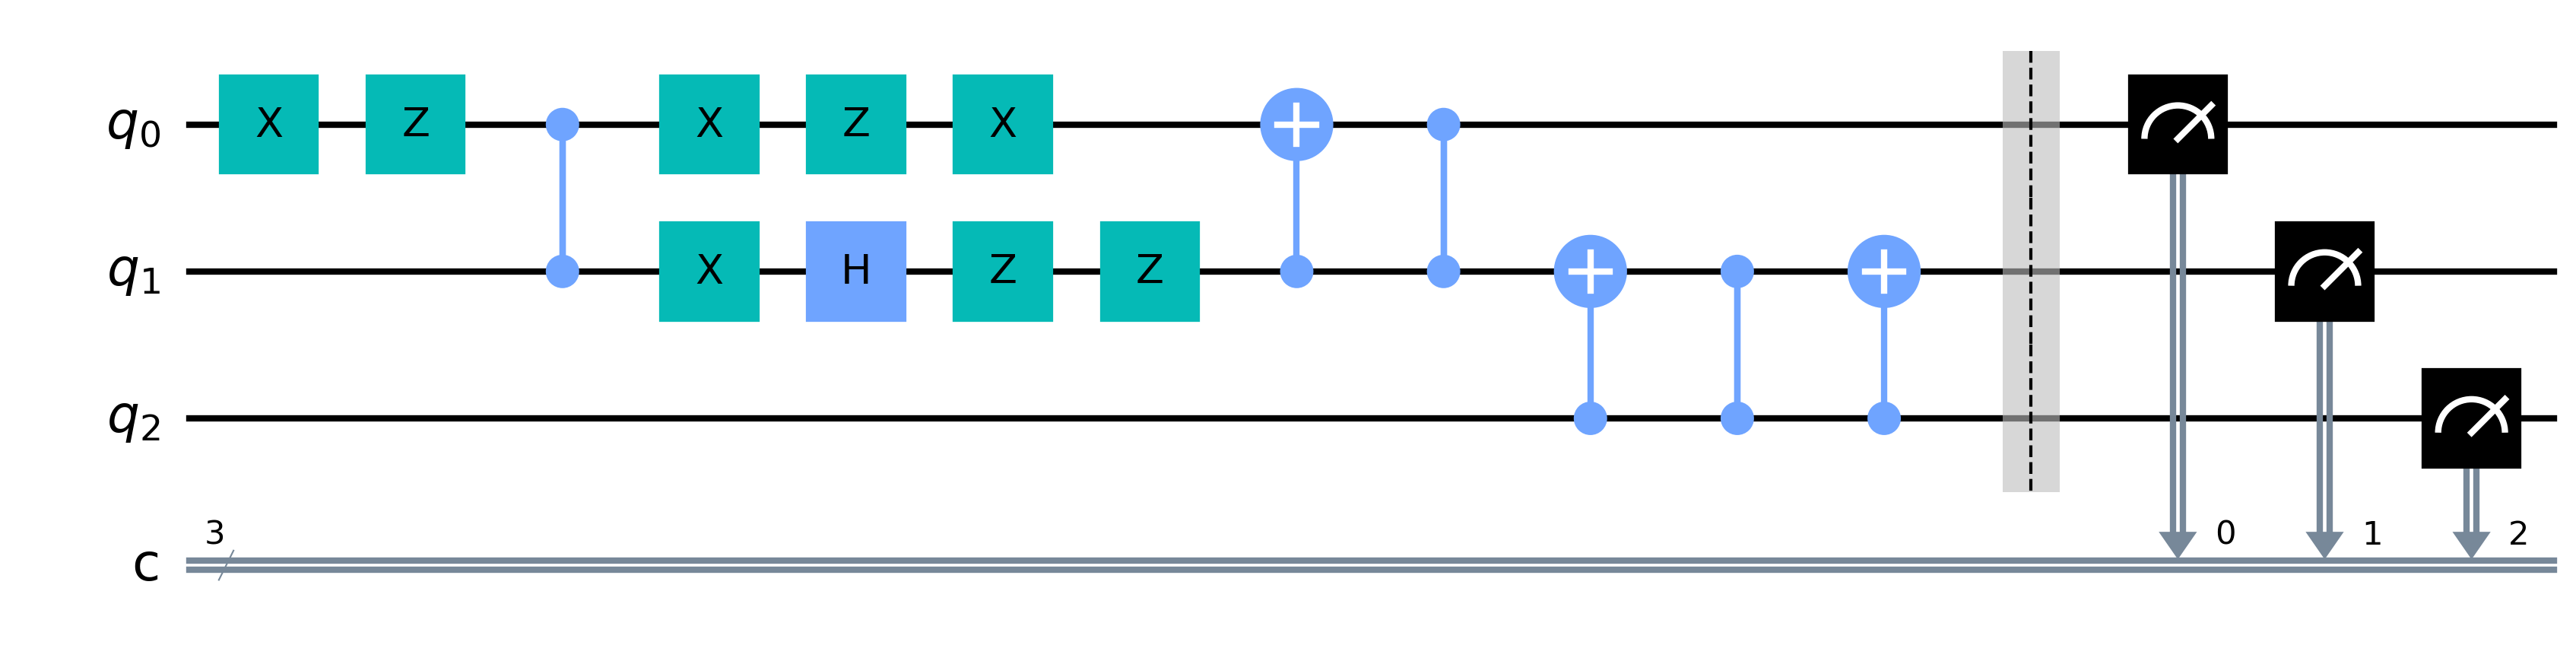

In [131]:
qc.draw('mpl', scale=3, filename='circuit.png')